In [1]:
# ### necessary to avoid a Tensorflow issue on my PC
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Just disables a TensorFlow warning, doesn't take advantage of AVX/FMA to run faster
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Changes floating point round-off
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#%matplotlib inline
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

from time import process_time
from math import frexp, ldexp
import cmath as cm
import scipy.stats as st
from sklearn.cluster import KMeans

import qutip as qt
from qutip_qip.operations import gate_sequence_product
import qutip_qip
from qutip_qip.circuit import CircuitSimulator
from qutip import basis, fidelity
from qutip_qip.device import LinearSpinChain
from qutip.qip.qasm import read_qasm
from qutip_qip.algorithms import qft_gate_sequence

import qiskit as qk
from qiskit.circuit.library import QFT, GroverOperator
from qiskit.algorithms import AmplificationProblem
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.compiler import transpile

2023-03-14 15:55:52.544823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:56:00.887949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-14 15:56:00.888640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-14 15:56:00.888679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you 

In [2]:
API_token = 'be527463519d46f32e9f93dd1429232e04d4eee32ec8b754f5c5435ebb92aad86a00dd60e5d3b349aab681e57f4cc5969e340617d48bc88730f33bd67791e2e3'
# saves API_token to disk
# IBMQ.save_account(API_token)
# If you want to load the permissions from the saved token on disk, run the following:
# provider = IBMQ.load_account()

# Otherwise, these commands will work given that we have printed the API token above
provider = IBMQ.enable_account(API_token)
backend = provider.get_backend('ibmq_qasm_simulator')

# Advanced setup for a specific provider, leave commented for the time being
# provider_2 = IBMQ.get_provider(hub='MY_HUB', group='MY_GROUP', project='MY_PROJECT')

/tmp/ipykernel_3717/2950507990.py:8: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.enable_account(API_token)
/tmp/ipykernel_3717/2950507990.py:8: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.enable_account(API_token)


In [3]:
import sys
print (sys.version)
# 3.10.8 | packaged by conda-forge | (main, Nov  4 2022, 13:42:51) [MSC v.1916 64 bit (AMD64)]
import tensorflow as tf
print("Tensorflow version: "+tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

### I have not been using tensorflow_gpu for any simulations, but it may be a good idea in the future if we want to do larger simulations.

3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:23:14) [GCC 10.4.0]
Tensorflow version: 2.11.0
Num GPUs Available:  0


2023-03-14 15:56:24.649131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-14 15:56:24.649387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Noah-Laptop): /proc/driver/nvidia/version does not exist


In [4]:
def roundbits(fval, nbits): # necessary function for rescaling floats used for the string data_type of gate_apply. Will probably change this in the future as I move to fixed point instead of flaoting point.
    """Return the floating-point value `fval` rounded to `nbits` bits
    in the significand."""
    significand, exponent = frexp(fval)
    scale = 2.0 ** nbits
    newsignificand = round(significand * scale) / scale
    return ldexp(newsignificand, exponent)

#### TO DO: Implement a better way to use the str data_type. Likely with fixed point numbers ###

def gate_apply(gate,state_vector,data_type=tf.float32,normalize=False):
    '''Function which converts gates and state vector into desired precision, then multiplies them. 
    The output state vector is recast into a QuTiP quantum object.'''
    # Inputs: 
    #  gate - numpy array or similar data structure
    #  state_vector - numpy array or similar data structure
    #  data_type - tensorflow datatype structure, or string (right now the string implementation does some sub-optimal things. I am going to change it soon)
    #  normalize - Boolean whether or not to normalize the output (this should be "True" for best results) 
    if type(data_type) == str:
        mantissa_bits = int(data_type[-1])
        real_gate = np.stack(np.vectorize(roundbits)(tf.cast(np.real(gate.full()),dtype=tf.float16),mantissa_bits), axis=1)
        imag_gate = np.stack(np.vectorize(roundbits)(tf.cast(np.imag(gate.full()),dtype=tf.float16),mantissa_bits), axis=1)
        
        real_state = np.stack(np.vectorize(roundbits)(tf.cast(np.real(state_vector.full()),dtype=tf.float16),mantissa_bits), axis=0)
        imag_state = np.stack(np.vectorize(roundbits)(tf.cast(np.imag(state_vector.full()),dtype=tf.float16),mantissa_bits), axis=0)
        
    else:
        real_gate = tf.cast(np.real(gate.full()),dtype=data_type)
        imag_gate = tf.cast(np.imag(gate.full()),dtype=data_type)

        real_state = tf.cast(np.real(state_vector.full()),dtype=data_type)
        imag_state = tf.cast(np.imag(state_vector.full()),dtype=data_type)
    
    # Above, I am breaking up the gate (i.e. Unitary matrix) into it's real and imaginary components, A and B, U=A+iB and
    # the state into s = x+iy. Then, Us = (A+iB)(x+iy)=(Ax-By)+i(Bx+Ay).
    # 
    real_final_state = tf.tensordot(real_gate,real_state,axes=1)-tf.tensordot(imag_gate,imag_state,axes=1) # (Ax-By)
    imag_final_state = tf.tensordot(imag_gate,real_state,axes=1)+tf.tensordot(real_gate,imag_state,axes=1) # (Bx+Ay)

    final_state = qt.Qobj(real_final_state.numpy()+1j*imag_final_state.numpy(),dims=state_vector.dims)
    
    if normalize == True:
        final_state = final_state.unit() # normalizes the output state
    
    return final_state

In [5]:
# Start the stopwatch / counter (only used for timing the process)
t1_start = process_time()

# normalize_states?
normalize_states = True
# Set the Number of Qubits
num_qubits = 5 # 5 qubits runs in a few minutes on my laptop. 10 qubits takes at least 8 hours
# Initial State
int_state = basis([2]*num_qubits, [0]*num_qubits) # input state is a basis vector of the 2^num_qubits dimentional space
#int_state = (basis([2]*num_qubits, [1]*num_qubits) + basis([2]*num_qubits, [0]*num_qubits)).unit() # superposition of two states

# Random initial state
#int_state = qt.rand_ket_haar(dims=int_state.dims).unit()
#int_state = qt.rand_ket(dims=int_state.dims).unit()

# The QFT circuit
### TO DO: Implement other circuits###
##### @Dorsa #####
# I am currently implementing the Quantum Fourier Transform. It is of direct interest to also test other algorithms, such as Grover Search, random circuit sampling, or QAOA.
qc = qft_gate_sequence(num_qubits, swapping=False, to_cnot=True)
#qc = read_qasm("my_circuit.qasm")
# sets the number of times to repeat the circuit (e.g. repeat=1 means the circuit is repeated once, for 2 total applications
# of the circuit)
# We want to set the number of repeats s.t. we have sufficently many gates to notice fidellity decay. This is O(10^3) gates.
# For 5 qubits, I've been using 30 repeats, and for 10 qubits, I've been using 10.
repeat = 30
for i in range(repeat):
    qc.add_circuit(qft_gate_sequence(num_qubits, swapping=False, to_cnot=True))
    #qc.add_circuit(read_qasm(qasm_input="grover_3qubits.qasm"))
# Gate-level simulation
### TO DO: Think about if this is the best "ideal state" to use for the fidelity calculation ###
# I am using this as a proxy for the "ideal" state. In reality, this is just Qutip using it's simulator to simulate the circuit with 64 bit precision.
# I need to think more about if this is a good reference state.
state1 = qc.run(int_state)

# Pulse-level simulation (P-L simulation takes a long time, don't run it unless you have few qubits.)
#processor = LinearSpinChain(num_qubits)
#processor.load_circuit(qc)
#state2 = processor.run_state(int_state).states[-1]
#print(fidelity(state1, state2))

gates = qc.propagators()
print('Number of total gates: '+str(len(gates)))

# Stop the stopwatch / counter
t1_stop = process_time()
print("Elapsed time during QuTiP circuit simulation in seconds:", t1_stop-t1_start)

Number of total gates: 2015
Elapsed time during QuTiP circuit simulation in seconds: 7.728282


In [6]:
# Prints image of Circuit. Only works for small circuits.

#qc.png

In [7]:
def gate_to_symbolic(gate_name,matrix):
    '''Inputs: gate_name: string of gate name as output by qiskit
               matrix: numpy array of gate'''
    if gate_name == 'h':
        return sp.sqrt(sp.Rational(1,2))*sp.Matrix(matrix*np.sqrt(2))
    if gate_name == 'cp':
        return_mat = matrix
        for index, value in np.ndenumerate(matrix):
            if np.isclose(value,0):
                return_mat[index] = 0
            else:
                return_mat[index] = sp.E**((np.angle(value)/np.pi)*sp.I*sp.pi)
        return sp.Matrix(return_mat)
    else:
        return print('Gate not supported. Please add new gate definition to gate_to_symbolic function.')


def qiskit_circuit_to_propagators(circuit,symbolic=False):
    '''
    This function takes a qiskit circuit and returns a list of propagators for each gate in the circuit. 
    If the symbolic flag is set to True, the propagators are returned as sympy matrices.
    '''
    propagators = [None]*len(circuit)
    for index, gate in enumerate(circuit.data):
        #print("\ngate name:",gate[0].name)
        #print("qubit(s) acted on:", gate[1])
        #print("other parameters (such as angles):", gate[0].params)
        temp_circ = QuantumCircuit(circuit.qubits,circuit.clbits)
        temp_circ.append(gate)
        #print(temp_circ.draw())
        if symbolic != True:
            propagators[index] = Operator(temp_circ)
        else:
            propagators[index] = gate_to_symbolic(gate.operation.name,Operator(temp_circ).data)
    return propagators

In [8]:
# Sets up the QFT circuit in Qiskit
qft = QFT(num_qubits=num_qubits, approximation_degree=0, do_swaps=False, inverse=False, insert_barriers=False, name='qft')
print(qft.decompose().draw()) # draws the circuit

qiskit_gates = qiskit_circuit_to_propagators(qft.decompose())
symbolic_gates = qiskit_circuit_to_propagators(qft.decompose(),symbolic=True) # the symbolic gates are generated by Sympy and will be used to compute the baseline which we will compare compressed outputs to.

print('Number of total gates: '+str(len(qiskit_gates)))

# Sanity check that ensures that the gates do in fact re-create the circuit unitary
holder_circ = QuantumCircuit(num_qubits)
holder_circ.x(1)
holder_circ.x(1)
holder = Operator(holder_circ)
for gate in qiskit_gates:
    holder = holder.compose(gate)
    
holder == Operator(qft)

                                                                           »
q_0: ─────────────────────────────────────────────────────────────■────────»
                                                                  │        »
q_1: ──────────────────────────────────────■─────────────■────────┼────────»
                                           │       ┌───┐ │        │        »
q_2: ────────────────────■────────■────────┼───────┤ H ├─┼────────┼────────»
                   ┌───┐ │        │P(π/2)  │       └───┘ │P(π/4)  │        »
q_3: ──────■───────┤ H ├─┼────────■────────┼─────────────■────────┼────────»
     ┌───┐ │P(π/2) └───┘ │P(π/4)           │P(π/8)                │P(π/16) »
q_4: ┤ H ├─■─────────────■─────────────────■──────────────────────■────────»
     └───┘                                                                 »
«                                              ┌───┐
«q_0: ──────────■─────────────■────────■───────┤ H ├
«               │       ┌───┐ │        │P(π/2) 

True

In [9]:
# print(gate_sequence_product(gates))
# print(Operator(qft))
# print()

print("Is the QuTiP circuit operator equal to (close enough) the Qiskit circuit operator?")
print(np.all(np.isclose(np.array(gate_sequence_product(gates)),np.array(Operator(qft)))))

# Note: While mathematically, these two should be the same, they are numerically different due two the two different simulators
# (i.e. 6.123234e-17 instead of 0)
print("Actual equality of the two operators:")
print(np.array(gate_sequence_product(gates)) == np.array(Operator(qft)))
#print(Operator(qft))
#print(gate_sequence_product(gates))

### Note to HaiQu: this should return False for the default parameters I have set. That is a artifact of how the code is currently written where the compression currently only works on QuTiP circuits. I will fix this in the future. ###

Is the QuTiP circuit operator equal to (close enough) the Qiskit circuit operator?
False
Actual equality of the two operators:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [10]:
### Grover Setup ###
# 3/7/2023 Not doing anyhting with Grover at the momennt, but will fully implement it later.

# the state we desire to find is '11'
good_state = ['11']

# Establish Oracle
oracle = QuantumCircuit(QuantumRegister(num_qubits,name='state'))
# specify the oracle that marks the state '11' as a good solution
oracle.cz(0, 1)  # good state = |11>

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)
grover_op = problem.grover_operator
print(grover_op.decompose().draw())

qiskit_gates = qiskit_circuit_to_propagators(grover_op.decompose())

global phase: π
              ┌───┐┌───┐     ┌───┐┌───┐     
state_0: ──■──┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
           │  ├───┤├───┤  │  ├───┤├───┤     
state_1: ──■──┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
         ┌───┐├───┤└───┘  │  ├───┤├───┤     
state_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         ├───┤├───┤       │  ├───┤├───┤     
state_3: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
         ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
state_4: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
         └───┘└───┘└───┘└───┘└───┘└───┘└───┘


In [11]:
#This codeblock just checks that the function gate_apply works as intended for all precisions by multiplying all gates
#together first, then calling gate_apply using that matrix and the initial state. Since there won't be any error propogation
#throughout the circuit, we expect all of these fidelities to be close to 1 (although lower for smaller precisions).

# You don't have to run this code, it's just a test.
# Also, I think fidelities >1 are numerical error.

# Start the stopwatch / counter
t2_start = process_time()

for precision in [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']:
    if type(precision) == str:
        precision_string = str(precision)
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    final_state = gate_apply(gate_sequence_product(gates),int_state,precision)
    print("Fidelity for percision "+precision_string+" is "+str(fidelity(final_state,state1)))
    
# Stop the stopwatch / counter
t2_stop = process_time()
print("Elapsed time during Final State fidelity check across precisions in seconds:", t2_stop-t2_start)

2023-03-14 15:56:37.680820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fidelity for percision complex128 is 1.0000000278293464
Fidelity for percision complex64 is 0.9999999753859816
Fidelity for percision float64 is 1.0000000278293464
Fidelity for percision float32 is 0.9999999753859816
Fidelity for percision float16 is 0.9997582533037581
Fidelity for percision bfloat16 is 0.998384483835119
Fidelity for percision float8 is 0.998384483835119
Fidelity for percision float7 is 0.998384483835119
Elapsed time during Final State fidelity check across precisions in seconds: 4.3312845999999965


In [12]:
# This codeblock tracks the state vector evolution after every gate application using QuTiP's native simulation engine. 
# We will use this series of state vectors to compare our results to using different precisions.

# Start the stopwatch / counter
t3_start = process_time()

#set up baseline using QuTIP native simulation
sim = qutip_qip.circuit.CircuitSimulator(qc, state=int_state)
state_vector = int_state
vector_list_baseline = []
vector_list_baseline.append(state_vector)
for i in range(len(gates)):
    state_vector = sim.step()
    if normalize_states == True:
        state_vector = state_vector.unit()
    vector_list_baseline.append(state_vector)
if normalize_states == True:
    qt.qsave(vector_list_baseline, name = 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+"_normalized")
else:
    qt.qsave(vector_list_baseline, name = 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))

# Stop the stopwatch / counter
t3_stop = process_time()
print("Elapsed time during baseline state vector evolution in seconds:", t3_stop-t3_start)

Elapsed time during baseline state vector evolution in seconds: 3.9884793000000016


In [13]:
### 3/7/2023: Currently re-working baseline computation to use symbolic manipulation (represented with the highest precision) instead of QuTiP's native simulation engine. ###

# # Start the stopwatch / counter
# t13_start = process_time()

# # Baseliine using symbolic manipulation
# sym_state = int_state
# sym_list_baseline = [None]*(len(symbolic_gates)+1)
# sym_list_baseline[0] = sp.Matrix(sym_state)
# for index, gate in enumerate(symbolic_gates):
#     sym_state = gate*sym_state
#     sym_list_baseline[index+1] = sym_state
# sp.pprint(sym_list_baseline)
# sym_list_baseline = np.array(sym_list_baseline,dtype=np.complex128)

# ## note: I don't think that anything needs to be done for the normalization here, since the symbolic states should already be normalized, but I'm leaving this in just to have a consistent saving convention.
# ## may need to re-work this in the future.
# if normalize_states == True:
#     qt.qsave(vector_list_baseline, name = 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+"_normalized")
# else:
#     qt.qsave(vector_list_baseline, name = 'vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))

# t13_stop = process_time()
# print("Elapsed time during baseline state vector evolution in seconds:", t13_stop-t13_start)


In [14]:
# As above, this codeblock keeps track of the state vector evolution throughout the circuit, but this time using the specified
# precisions. Each result is saved as a QuTiP file to be accessed later without having to redo calculations.

# Start the stopwatch / counter
t4_start = process_time()

#set up test w/ different percision
precisions_to_test = [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
for precision in precisions_to_test:
    vector_list = []
    state_vector = int_state
    vector_list.append(state_vector)
    for gate in gates:
        if normalize_states == True:
            state_vector = gate_apply(gate,state_vector,data_type=precision,normalize=True)
        else:
            state_vector = gate_apply(gate,state_vector,data_type=precision)
        vector_list.append(state_vector)
    if normalize_states == True:
        if type(precision) == str:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'
        else:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
    else:
        if type(precision) == str:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
        else:
            filename = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    qt.qsave(vector_list,filename)
    
# Stop the stopwatch / counter
t4_stop = process_time()
print("Elapsed time during test state vector evolution in seconds:", t4_stop-t4_start)

Elapsed time during test state vector evolution in seconds: 75.5556495


In [15]:
def vector_encoding(vector_list,normalize_states,repeat,precision_string,NUM_CODEWORDS=8,num_iter=100):
    ### Fucntion for defining the vector quantizer encoding###
    
    num_qubits = int(np.log2(np.shape(vector_list)[1]))
    # Complex Coordinates
    x = np.real(vector_list).flatten()
    y = np.imag(vector_list).flatten()
    # polar coordinates
    R = np.abs(vector_list).flatten()
    phi = np.angle(vector_list).flatten()

    complex_points = [1,1]
    complex_points[0] = np.vstack((x,y)).T
    complex_points[1] = np.vstack((R,phi)).T
    
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    fig.suptitle("Amplitudes in Complex Plane for "+ precision_string)
    
    for index, samples in enumerate(complex_points):

        NUM_SAMPLES = samples.shape[0]
        initial_points = np.random.choice(NUM_SAMPLES, size=NUM_CODEWORDS, replace=False)
        initial_points = samples[initial_points,:]
        kmeans = KMeans(n_clusters= NUM_CODEWORDS, init=initial_points, n_init=1, max_iter=num_iter)
        labels = kmeans.fit_predict(samples)
        centroids = kmeans.cluster_centers_
        
        for i in range(NUM_CODEWORDS):
            ax[index].scatter(samples[labels == i, 0] , samples[labels == i, 1] , label = i, alpha=0.5)
        ax[index].scatter(centroids[:,0] , centroids[:,1] , s = 200, color = 'k', marker = 'x')
        ax[index].axvline(x=0, c="k", linewidth=0.2)
        ax[index].axhline(y=0, c="k", linewidth=0.2)
        
        #fig.subplots_adjust(wspace= 0.3)
        fig.tight_layout(w_pad = 3, h_pad = 3)
        ax[0].set(title = "Real vs. Imag Components", xlabel = 'Real Components', ylabel = 'Imaginary Components')
        ax[1].set(title = "Polar Coordinates", xlabel = 'R', ylabel = 'phi')
        
        #ax.axis('equal')

        if index == 0:
            xy_codewords = centroids[:,0]+1j*centroids[:,1]
        elif index == 1:
            Rphi_codewords = centroids[:,0]*np.exp(1j*centroids[:,1])

    fig2 = plt.figure()
    plt.scatter(np.real(xy_codewords) , np.imag(xy_codewords), s = 200,  marker = 'x',label="xy")
    plt.scatter(np.real(Rphi_codewords) , np.imag(Rphi_codewords), s = 200,  marker = 'o',label="Rphi")
    plt.xlabel("Real Component")
    plt.ylabel("Imaginary Compnent")
    plt.title("K-means Codewords from xy vs. Rphi")
    plt.legend()
    
    codeword_savename = 'codewords_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)
    if normalize_states == True:
        fig.savefig('codewords_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)+'_normalized'+'.jpg')
        fig2.savefig('codewords_compare_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)+'_normalized'+'.jpg')
        codeword_savename = codeword_savename + '_normalized'
    else:
        fig.savefig('codewords_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)+'.jpg')
        fig2.savefig('codewords_compare_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)+'.jpg')
    
    qt.qsave(xy_codewords,"xy_"+codeword_savename)
    qt.qsave(Rphi_codewords,"Rphi_"+codeword_savename)
    
# Runs a test of the function
#vector_encoding(vector_list,NUM_CODEWORDS=8,num_iter=100)

#diff = np.ones(len(Rphi_codewords))
#closest_vector = np.ones((len(Rphi_codewords),2,2))
#for index,value in enumerate(Rphi_codewords):
#    similarity = np.abs(xy_codewords-value)**2
#    diff[index] = np.min(similarity)
#    p[index,0,:] = value
#    p[index,1,:] = xy_codewords[np.argmin(similarity)]
#print(diff)

In [16]:
def save_load_names(normalize_states,precision,num_qubits,repeat):
    ### just a function to load the data files based on the naming convention we are using###
    if normalize_states == True:
        vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_normalized')
        if type(precision) == str:
            precision_string = precision
        else:
            precision_string = str(precision)[str(precision).find(' ')+2:-2]
        loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'
        savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'      
    else:
        vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
        if type(precision) == str:
            precision_string = precision
        else:
            precision_string = str(precision)[str(precision).find(' ')+2:-2]
        loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string
        savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string
    return loadname, savename, precision_string, vector_list_baseline

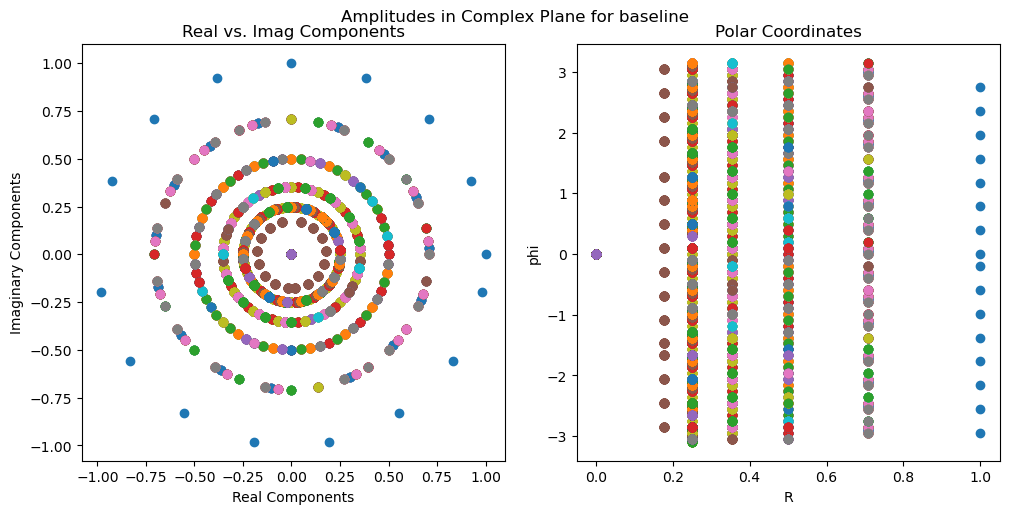

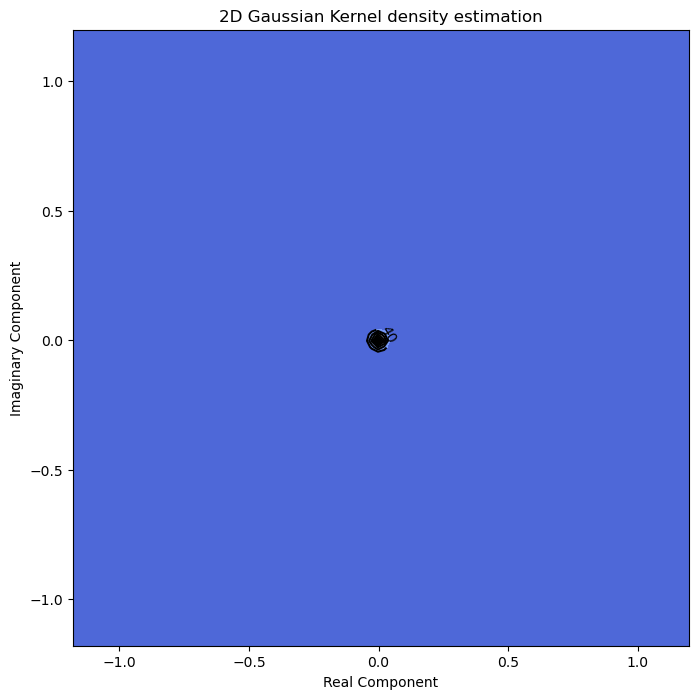

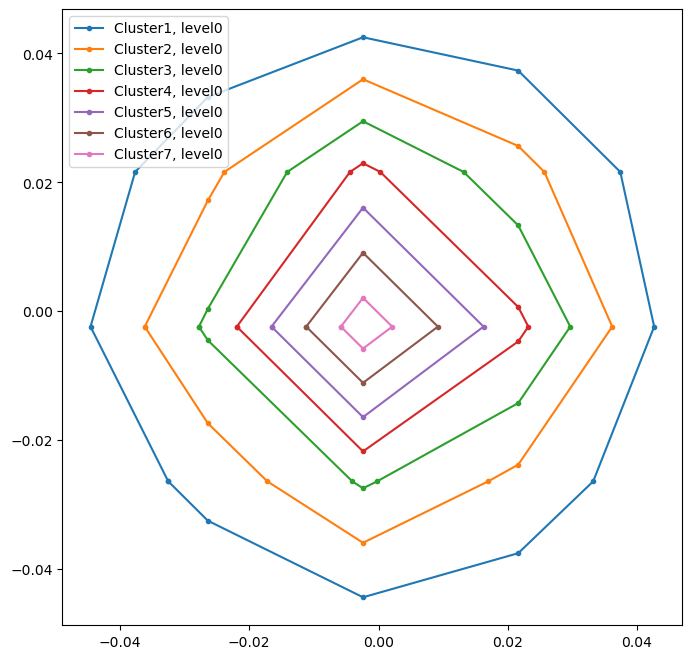

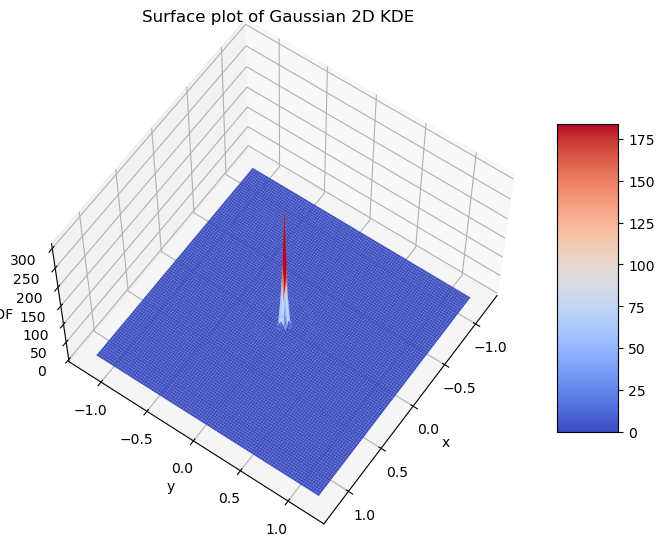

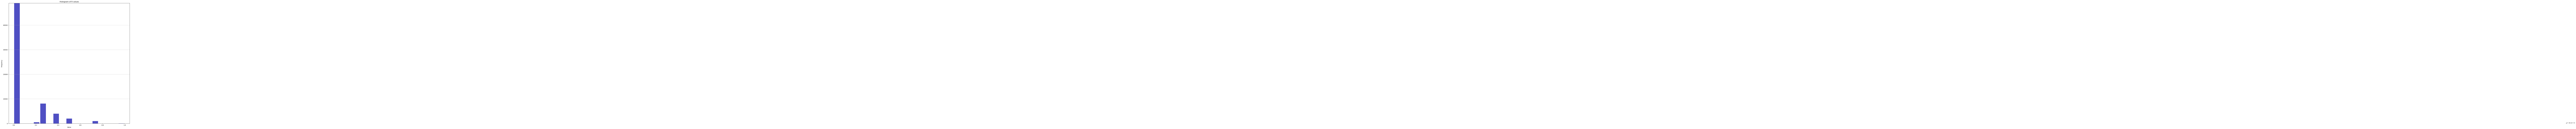

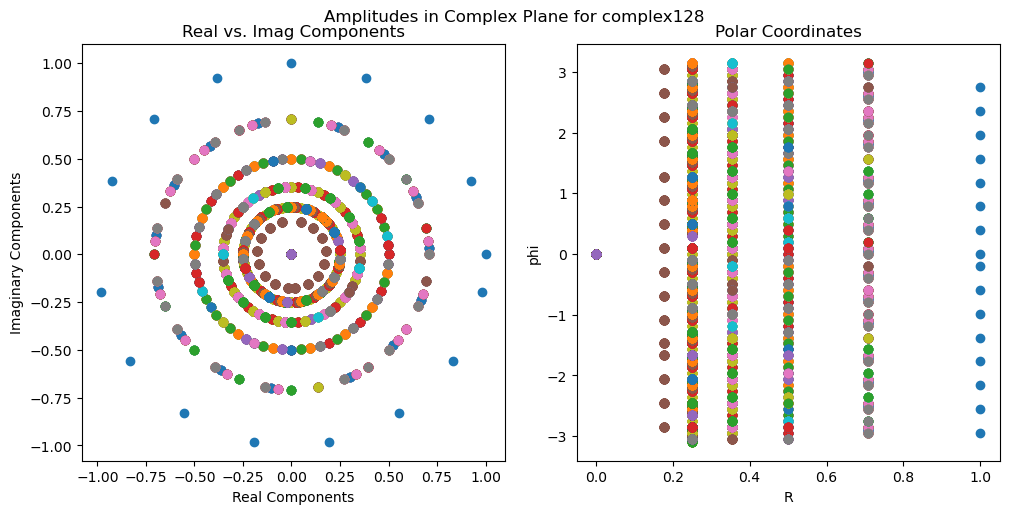

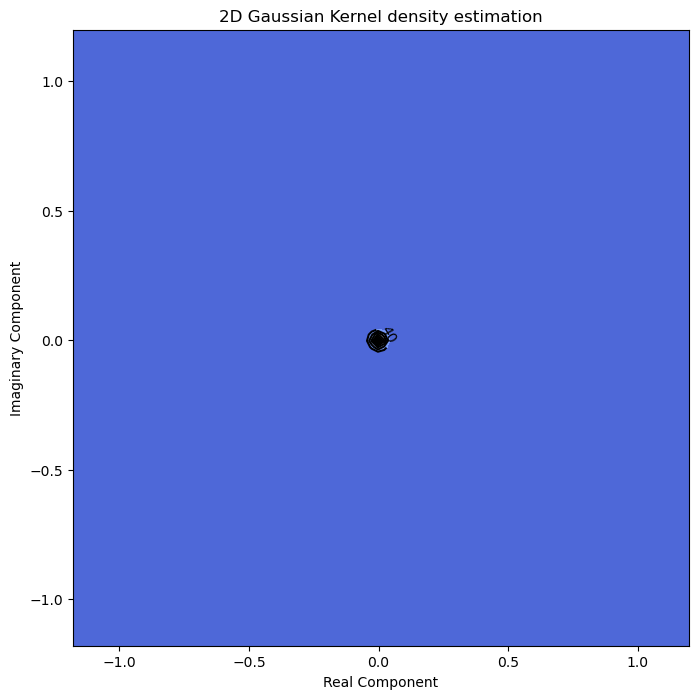

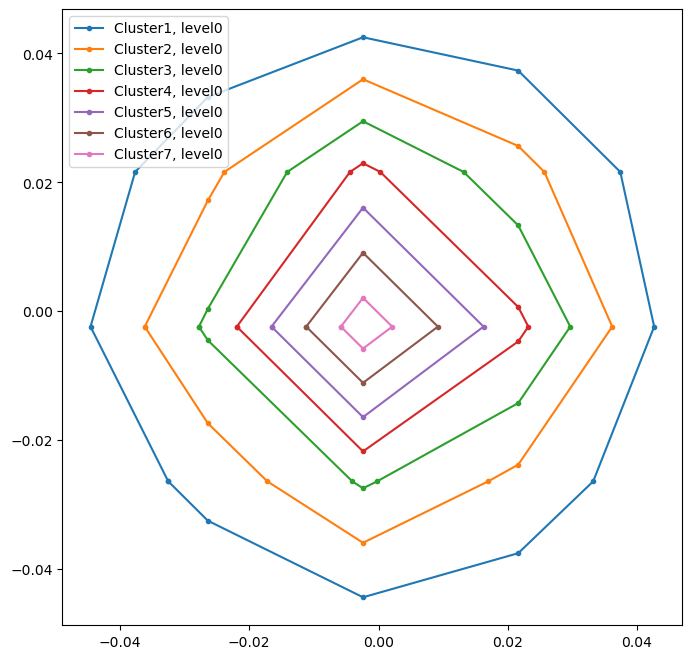

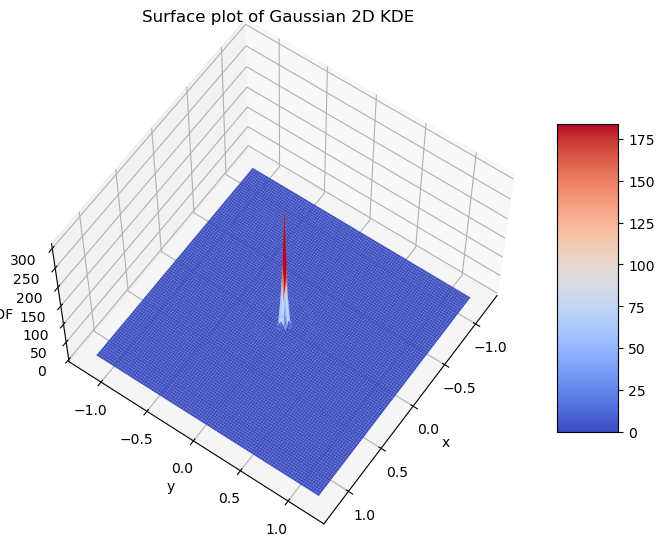

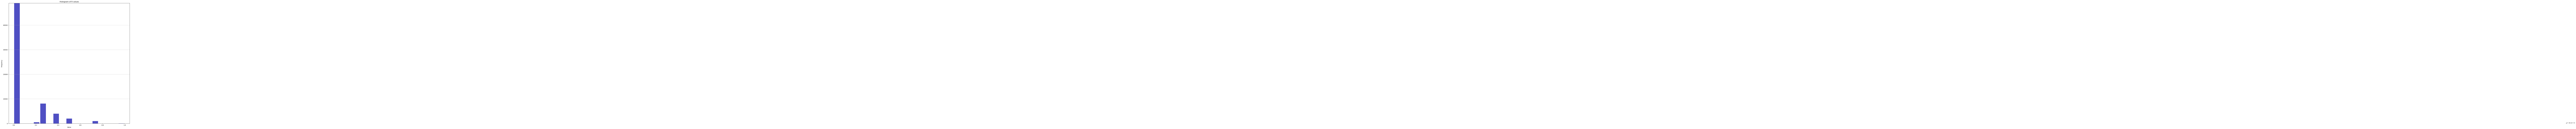

: 

: 

In [17]:
### plotting the real and imaginary parts to see if there is any correlation

normalize_states = True
num_qubits = 5
repeat = 30
#precisions_to_test = ["baseline",tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
precisions_to_test = ["baseline",tf.complex128,tf.complex64]

# Start the stopwatch / counter
t10_start = process_time()

for precision in precisions_to_test:

    fig, axs = plt.subplots(1,2,figsize=[10, 5])
    
    if precision == "baseline":
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,tf.float32,num_qubits,repeat)
        precision_string = "baseline"
        vector_list = vector_list_baseline
    else:
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,precision,num_qubits,repeat)
        vector_list = qt.qload(loadname)
    
    # iterates over 
    label = 0
    for psi in vector_list:
        label += 1
        name = "Time Step" + str(label)
        x_axes_data = np.real(psi)
        y_axes_data = np.imag(psi)
        R = np.abs(np.array(psi)) 
        phi = np.angle(np.array(psi))
    
        #x_axes_data = []
        #y_axes_data = []
        #for amp in psi:
        #    r = np.real(amp)
        #    im = np.imag(amp)
        #    x_axes_data.append(r)
        #    y_axes_data.append(im)
            
        axs[0].scatter(x_axes_data, y_axes_data,label=name)
        axs[1].scatter(R,phi,label=name)
        
    fig.suptitle("Amplitudes in Complex Plane for "+precision_string)
    #fig.subplots_adjust(wspace= 0.3)
    fig.tight_layout(w_pad = 3, h_pad = 3)
    axs[0].set(title = "Real vs. Imag Components", xlabel = 'Real Components', ylabel = 'Imaginary Components')
    axs[1].set(title = "Polar Coordinates", xlabel = 'R', ylabel = 'phi')
    #fig.legend()
    if normalize_states == True:
        fig.savefig('Complex_Amplitudes_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'+'.jpg')
    else:
        fig.savefig('Complex_Amplitudes_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'.jpg')
        
    # Define the borders
    x = np.real(vector_list).flatten()
    y = np.imag(vector_list).flatten()
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY
    # print(xmin, xmax, ymin, ymax)
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    # fit a gaussian kernel using the scipy’s gaussian_kde method
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
        

    fig2 = plt.figure(figsize=(8,8))
    ax = fig2.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('Real Component')
    ax.set_ylabel('Imaginary Component')
    plt.title('2D Gaussian Kernel density estimation')
    
    if normalize_states == True:
        fig2.savefig('pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'+'.jpg')
    else:
        fig2.savefig('pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'.jpg')
    
    # Cluster Plot
    fig3 = plt.figure(figsize=(8,8))
    for j in range(len(cset.allsegs)):
        for ii, seg in enumerate(cset.allsegs[j]):
            plt.plot(seg[:,0], seg[:,1], '.-', label=f'Cluster{j}, level{ii}')
    plt.legend()
    
    if normalize_states == True:
        fig3.savefig('cluster_pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'+'.jpg')
    else:
        fig3.savefig('cluster_pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'.jpg')
        
    # 3D Contour
    fig4 = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('PDF')
    ax.set_title('Surface plot of Gaussian 2D KDE')
    fig4.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
    ax.view_init(60, 35)
    
    if normalize_states == True:
        fig4.savefig('3D_contour_pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'+'.jpg')
    else:
        fig4.savefig('3D_contour_pdf_for_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'.jpg')
    
    #### Histogram of R values
    # polar coordinates
    R = np.abs(vector_list).flatten()
    phi = np.angle(vector_list).flatten()
    
    hist, bin_edges = np.histogram(R)
    
    # An "interface" to matplotlib.axes.Axes.hist() method
    fig5, ax5 = plt.subplots(figsize =(15, 15))
    n, bins, patches = ax5.hist(x=R, bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of R values')
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()
    
    
# Stop the stopwatch / counter
t10_stop = process_time()
print("Elapsed time in seconds:", t10_stop-t10_start)

Elapsed time in seconds: 76.58963929999999


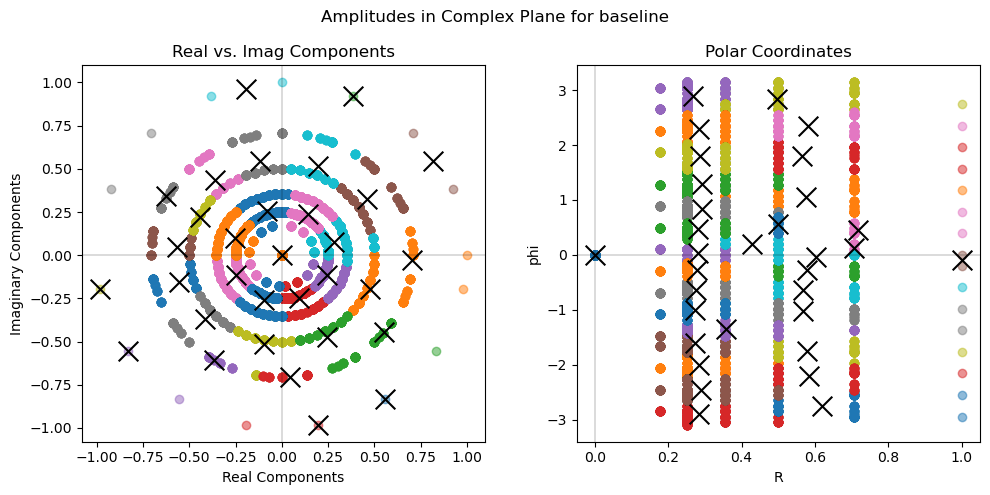

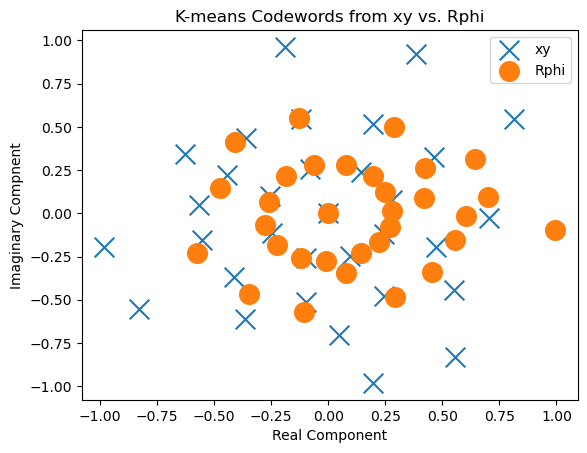

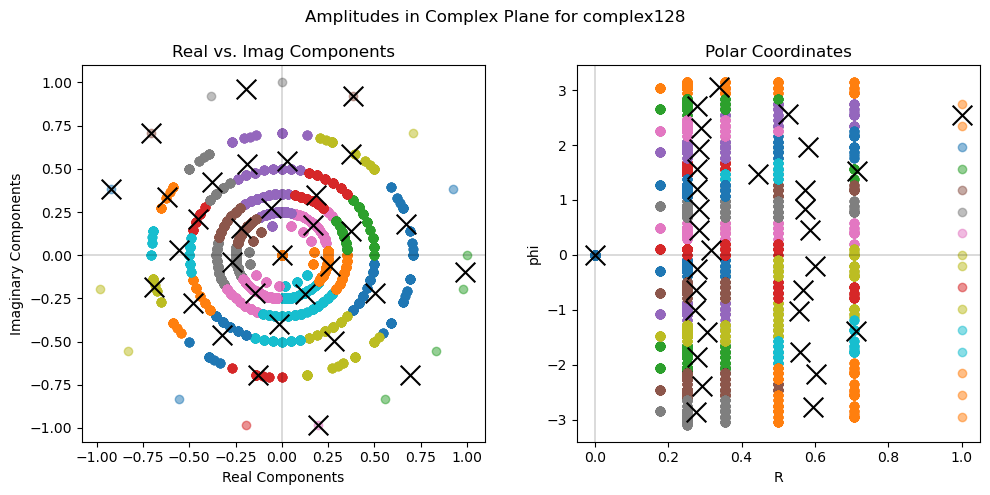

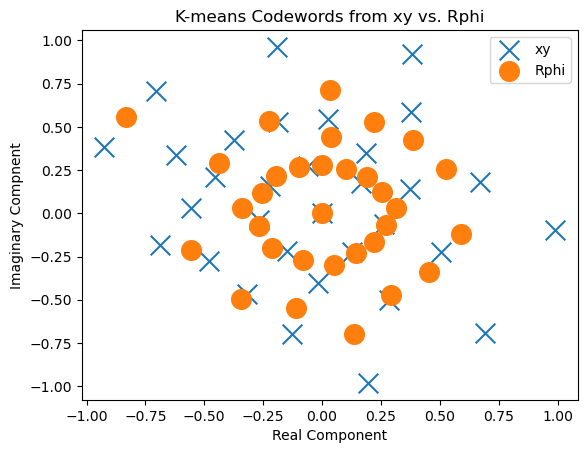

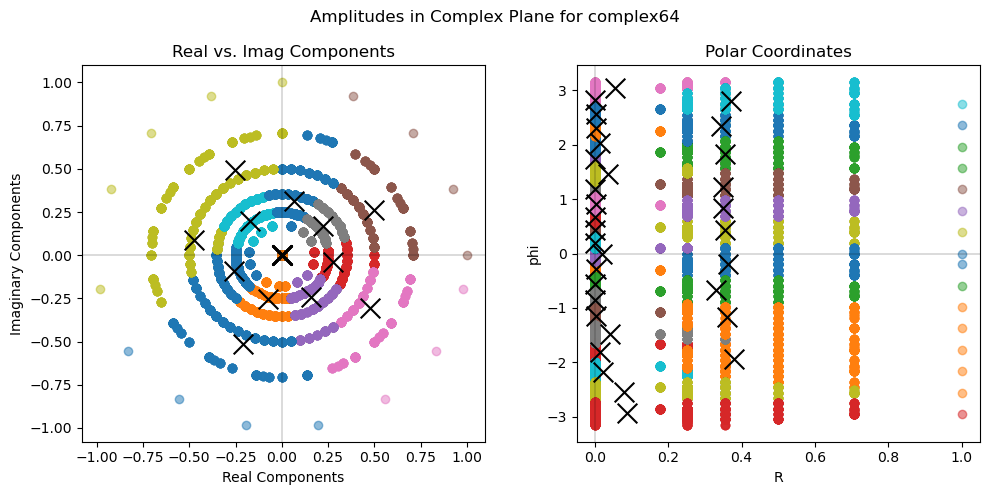

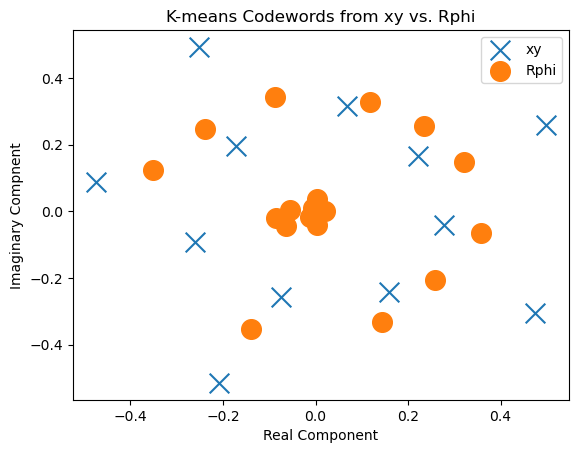

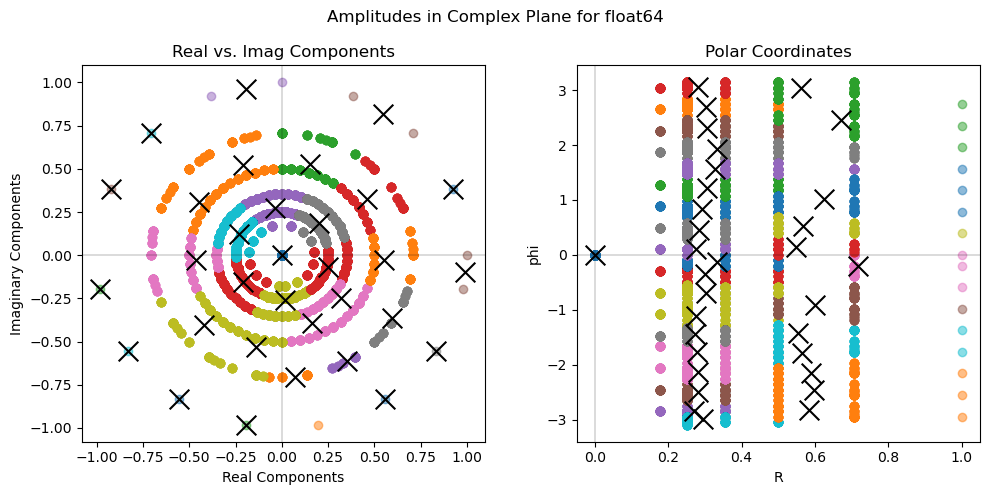

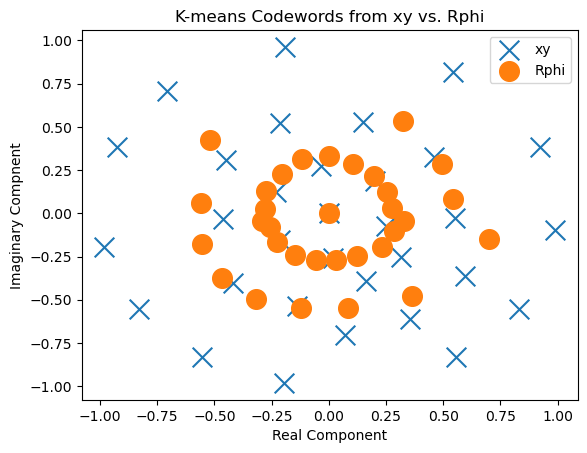

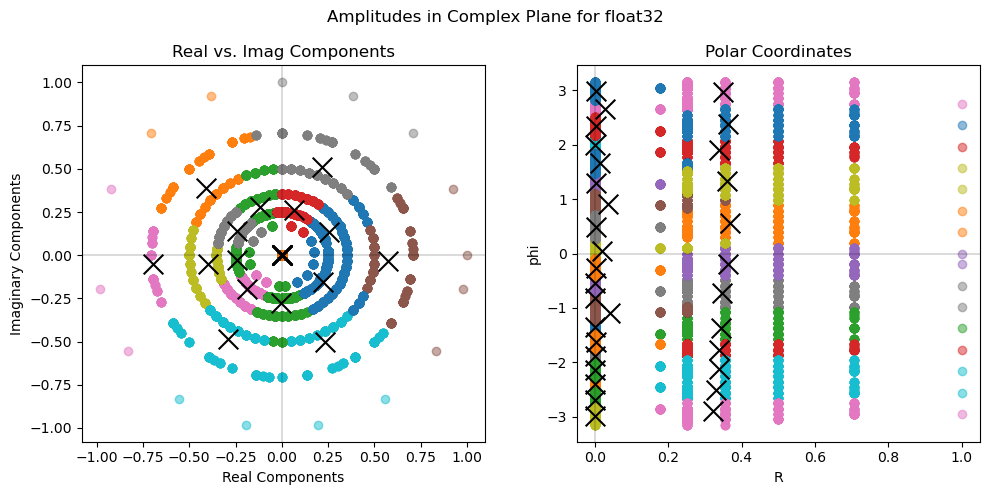

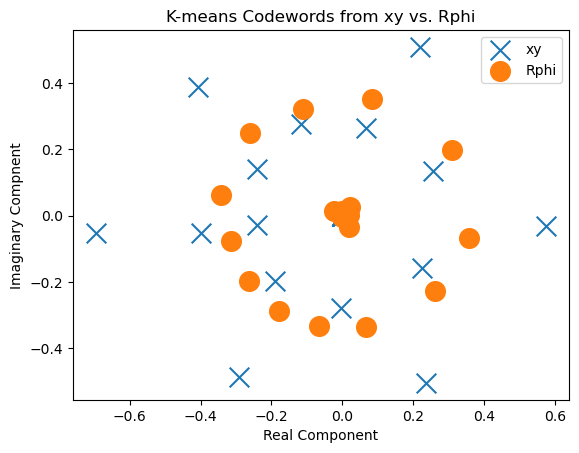

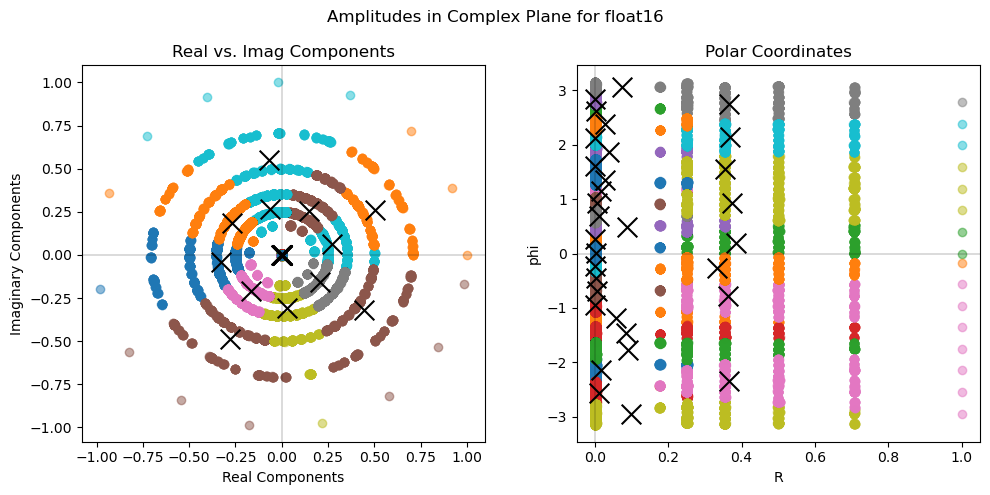

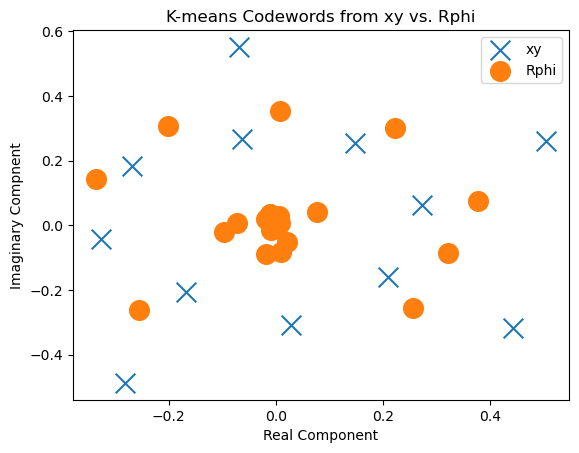

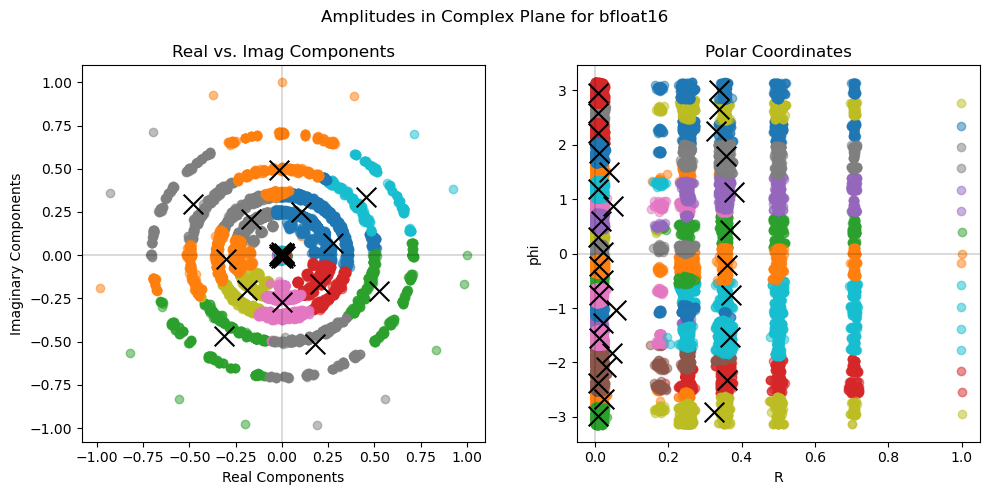

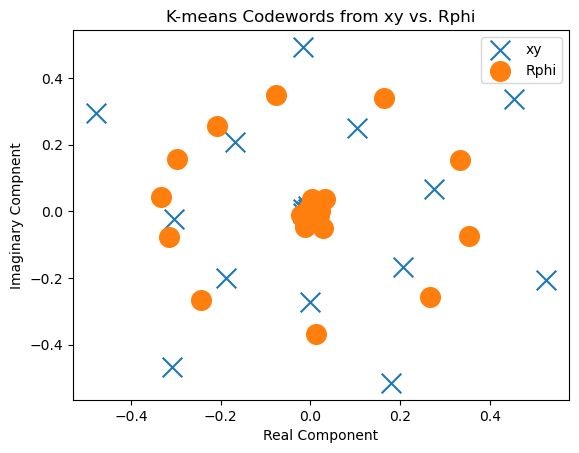

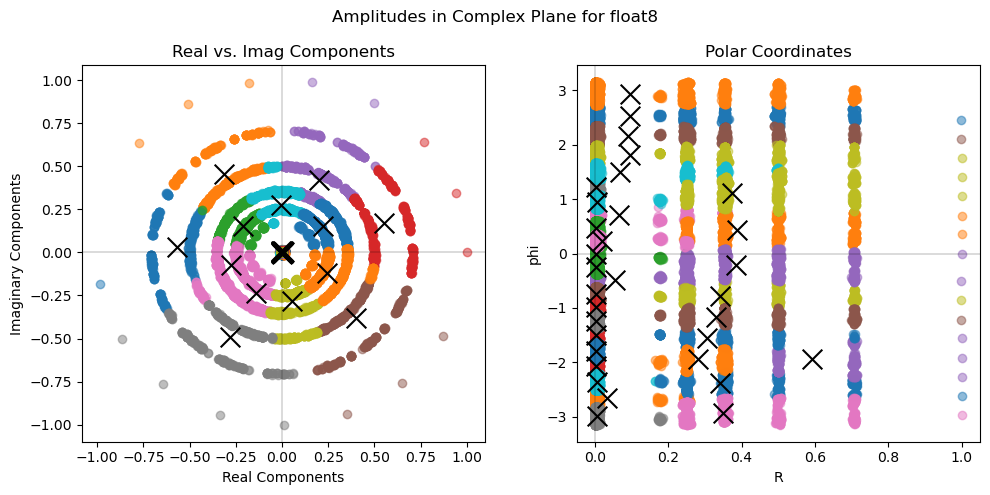

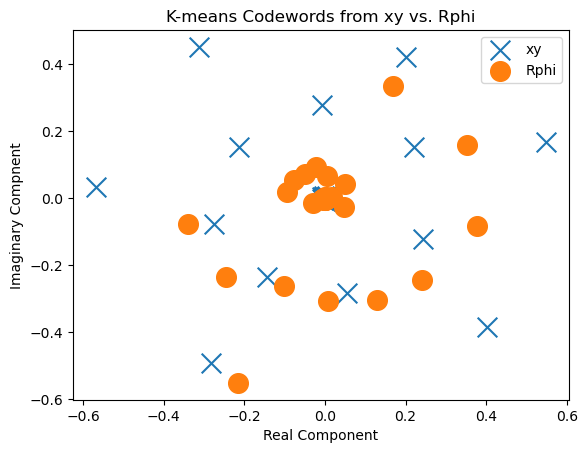

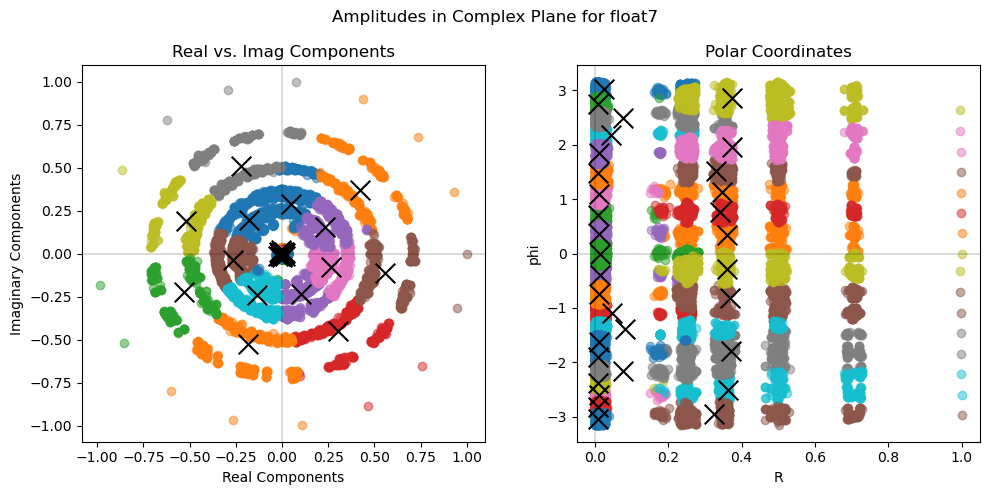

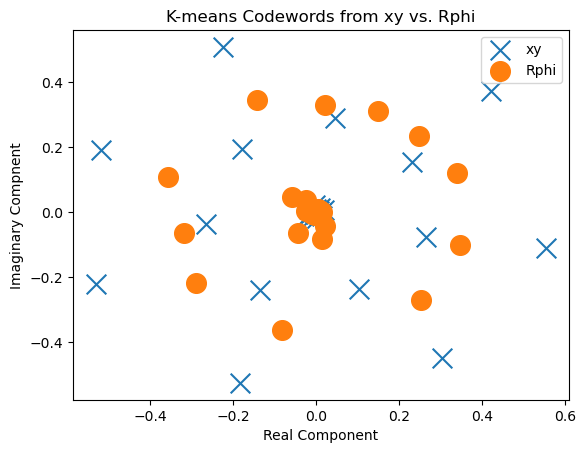

In [17]:
normalize_states = True
num_qubits = 5
repeat = 30
precisions_to_test = ["baseline",tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
NUM_CODEWORDS = 2**5
num_iter = 1000

# Start the stopwatch / counter
t11_start = process_time()

for precision in precisions_to_test:
    
    if precision == "baseline":
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,tf.float32,num_qubits,repeat)
        precision_string = "baseline"
        vector_list = vector_list_baseline
    else:
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,precision,num_qubits,repeat)
        vector_list = qt.qload(loadname)
    
    #print(len(vector_list))
    vector_encoding(vector_list,normalize_states,repeat,precision_string,NUM_CODEWORDS,num_iter)
    
# Stop the stopwatch / counter
t11_stop = process_time()
print("Elapsed time in seconds:", t11_stop-t11_start)

In [18]:
def mse(v1, v2):
    """
    computes the mean square error
    """
    d = np.linalg.norm(v1 - v2, ord=2)  # l2_norm
    loss = d * d / (v1.size)  # avg l2 loss
    return loss

def find_nearest(codebook_npy: np.array, data_vector_npy: np.array, dist_func: callable):
    """
    Finds nearest codeword given data vectors
    codebook_npy -> [V,D] where V -> num vectors in the codebook, D -> dim of each vector
    data_vector_npy -> [D] sized vector
    """
    distances = [dist_func(c, data_vector_npy) for c in codebook_npy]
    min_ind = np.argmin(distances)
    return min_ind, distances[min_ind]

In [19]:
#### Encoding ###
normalize_states = True
num_qubits = 5
repeat = 30
precisions_to_test = ["baseline",tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
#precisions_to_test = [tf.float32]
NUM_CODEWORDS = 2**5
num_iter = 1000

# Start the stopwatch / counter
t11_start = process_time()

for precision in precisions_to_test:
    
    if precision == "baseline":
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,tf.float32,num_qubits,repeat)
        precision_string = "baseline"
        vector_list = vector_list_baseline
    else:
        loadname, savename, precision_string, vector_list_baseline = save_load_names(normalize_states,precision,num_qubits,repeat)
        vector_list = qt.qload(loadname)

    codeword_savename = 'codewords_'+str(num_qubits)+'_qubits'+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+"_codewords_"+str(NUM_CODEWORDS)
    if normalize_states == True:
        codeword_savename = codeword_savename + "_normalized"
    xy_codewords = qt.qload("xy_"+codeword_savename)
    xy_codewords_array = np.array([np.real(xy_codewords),np.imag(xy_codewords)]).T
    Rphi_codewords = qt.qload("Rphi_"+codeword_savename)
    Rphi_codewords_array = np.array([np.real(Rphi_codewords),np.imag(Rphi_codewords)]).T
    
    for codeword_array in [xy_codewords_array,Rphi_codewords_array]:
        vector_list = []
        state_vector = int_state
        vector_list.append(state_vector)
        if precision == "baseline":
            for gate in gates:
                state_vector = tf.tensordot(gate.full(),state_vector.full(),axes=1)
                state_holder = np.ones(len(np.array(state_vector)),dtype=np.complex_)
                for index,complex_number in enumerate(np.array(state_vector)):
                        complex_number = complex_number[0]
                        min_ind,_ = find_nearest(codeword_array, (np.real(complex_number),np.imag(complex_number)), mse)
                        state_holder[index] = codeword_array[min_ind,0]+1j*codeword_array[min_ind,1]
                state_vector = qt.Qobj(state_holder)
                vector_list.append(state_vector)
        else:
            for i, gate in enumerate(gates):
                
                state_vector = gate_apply(gate,state_vector,data_type=precision,normalize=normalize_states)
                
                state_holder = np.ones(len(np.array(state_vector)),dtype=np.complex_)
                for index,complex_number in enumerate(np.array(state_vector)):
                    complex_number = complex_number[0]
                    min_ind,dist = find_nearest(codeword_array, (np.real(complex_number),np.imag(complex_number)), mse)
                    state_holder[index] = codeword_array[min_ind,0]+1j*codeword_array[min_ind,1]
                state_vector = qt.Qobj(state_holder)
                if normalize_states == True:
                    state_vector = state_vector.unit() # normalizes the output state
                vector_list.append(state_vector)

        if (codeword_array == xy_codewords_array).all():
            code_str = "xy_"
        elif (codeword_array == Rphi_codewords_array).all():
            code_str = "Rphi_"
            
        if normalize_states == True:
            filename = code_str +'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'
        else:
            filename = code_str + 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string
        qt.qsave(vector_list,filename)
        

# Stop the stopwatch / counter
t11_stop = process_time()
print("Elapsed time in seconds:", t11_stop-t11_start)

Elapsed time in seconds: 946.0481735


Elapsed time during fidelity plotting evolution in seconds: 42.9871462000001


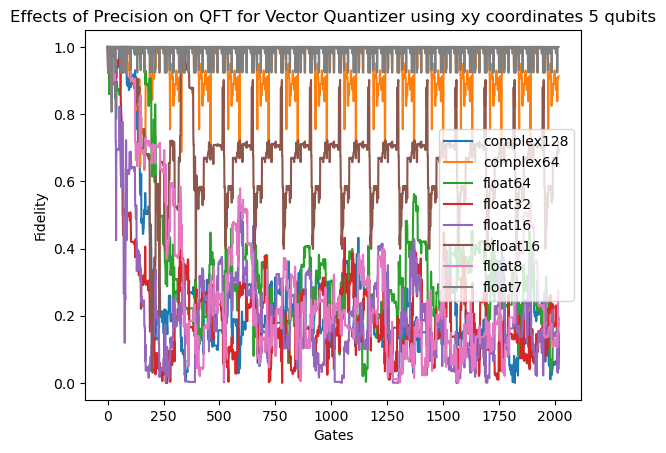

In [22]:
# Computes, then plots the fidelity of each state vector at every precision vs. the baseline.

normalize_states = True
num_qubits = 5
repeat = 30
precisions_to_test = [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16,tf.bfloat16,'float8','float7']
#precisions_to_test = [tf.float32]
vector_quantizer = True
xy = True
Rphi = False

# Start the stopwatch / counter
t5_start = process_time()

if normalize_states == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
    
fig = plt.figure()

for precision in precisions_to_test:
    if vector_quantizer == True:
        if xy == True and Rphi == False:
            load_string_prefix = "xy_" + 'vector_list_num_qbits_'
            save_string_prefix = "xy_" + 'fidelity_list_num_qbits_'
            fig_save_string_prefix = "xy_" + 'Effects_of_Precision_on_QFT_for_'
            plt_title = 'Effects of Precision on QFT for Vector Quantizer using xy coordinates'
        elif xy == False and Rphi == True:
            load_string_prefix = "Rphi_" + 'vector_list_num_qbits_'
            save_string_prefix = "Rphi_" + 'fidelity_list_num_qbits_'
            fig_save_string_prefix = "Rphi_" + 'Effects_of_Precision_on_QFT_for_'
            plt_title = 'Effects of Precision on QFT for Vector Quantizer using Rphi coordinates'
        else:
            print("Please only set one of xy or Rphi to True")
            break
    else:
        load_string_prefix = 'vector_list_num_qbits_'
        save_string_prefix = 'fidelity_list_num_qbits_'
        fig_save_string_prefix = 'Effects_of_Precision_on_QFT_for_'
        plt_title = 'Effects of Precision on QFT for '
    if normalize_states == True: 
        if type(precision) == str:
            precision_string = precision  
        else:
            precision_string = str(precision)[str(precision).find(' ')+2:-2]
        loadname = load_string_prefix+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'
        savename = save_string_prefix+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string+'_normalized'      
    else:
        if type(precision) == str:
            precision_string = precision
        else:
            precision_string = str(precision)[str(precision).find(' ')+2:-2]
        loadname = load_string_prefix+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string
        savename = save_string_prefix+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision_string
    
    vector_list = qt.qload(loadname)
    # print(vector_list)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(qt.Qobj(vector_list[i].full()),qt.Qobj(vector_list_baseline[i].full())))
    qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title(plt_title+" "+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
if normalize_states == True:
    fig.savefig(fig_save_string_prefix+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'_normalized'+'.jpg')
else:
    fig.savefig(fig_save_string_prefix+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'.jpg')
# Stop the stopwatch / counter
t5_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t5_stop-t5_start)

In [ ]:
# BREAK: Note to Noah - When running cells, you can stop here to save time

In [ ]:
# Post Normalization
# Above, if normalize_states = True, the code automatically normalizes the state vector during computation. It was of interest
# to see what would happen if we first computed all of the state vectors via simulation, then went back and normalized them.
# This has approximately the same effect as normalization during simulation, which is what I recomend.

normalize_states_2 = False
# Start the stopwatch / counter
t6_start = process_time()

if normalize_states_2 == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat))
fig = plt.figure()
for precision in precisions_to_test:
    if normalize_states == True:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision+'_normalized'      
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'      
    else:
        if type(precision) == str:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+precision
        else:
            loadname = 'vector_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
            savename = 'fidelity_list_num_qbits_'+str(num_qubits)+'_circuit_repeats_'+str(repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]

    if type(precision) == str:
        precision_string = precision
    else:
        precision_string = str(precision)[str(precision).find(' ')+2:-2]
    vector_list = qt.qload(loadname)
    fidelity_list = []
    for i in range(len(vector_list)):
        fidelity_list.append(fidelity(vector_list[i].unit(),vector_list_baseline[i].unit())) #normalizing before fidelity
    #qt.qsave(fidelity_list,savename)   
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
fig.savefig('Effects of Precision on QFT for '+str(num_qubits)+' qubits'+'_circuit_repeats_'+str(repeat)+'post_normalization'+'.jpg')

# Stop the stopwatch / counter
t6_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t6_stop-t6_start)

Elapsed time during fidelity plotting evolution in seconds: 0.0


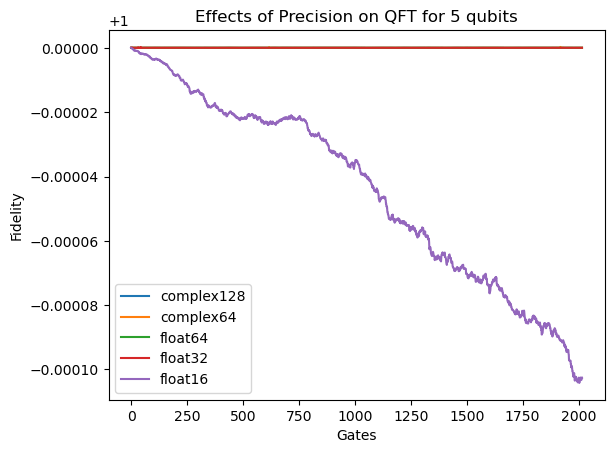

In [12]:
#### Plotting Testbed

# This is just a playground to plot the various data without having to re-compute anything. Since all the code above
# saves results as Qutip objects, you can easily load them in and compare plots.

#load_num_qubits = num_qubits
#load_repeat = repeat
load_num_qubits = 5
load_repeat = 30

saving = False # whether or not to save the output plots
normal = True

# Start the stopwatch / counter
t10_start = process_time()

if normal == True:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_normalized')
else:
    vector_list_baseline = qt.qload('vector_list_baseline_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat))
fig2 = plt.figure()
for precision in [tf.complex128,tf.complex64,tf.float64,tf.float32,tf.float16]: # precisions to plot
    if normal == True:
        loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]+'_normalized'
    else:
        loadname = 'fidelity_list_num_qbits_'+str(load_num_qubits)+'_circuit_repeats_'+str(load_repeat)+'_precision_'+str(precision)[str(precision).find(' ')+2:-2]
    precision_string = str(precision)[str(precision).find(' ')+2:-2]
    fidelity_list = qt.qload(loadname)
    plt.plot(fidelity_list,label=precision_string)
plt.title('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits')
plt.xlabel('Gates')
plt.ylabel('Fidelity')
plt.legend()
if saving == True:
    if normal == True:
        fig.savefig('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits'+'_circuit_repeats_'+str(load_repeat)+'_normalized'+'.jpg')
    else:
        fig.savefig('Effects of Precision on QFT for '+str(load_num_qubits)+' qubits'+'_circuit_repeats_'+str(load_repeat)+'.jpg')
# Stop the stopwatch / counter
t10_stop = process_time()
print("Elapsed time during fidelity plotting evolution in seconds:", t10_stop-t10_start)